# Analysing Feature Dependencies, Constructing Classess with OOP


In this notebook, we will investigate the feature dependencies. Why is it important?
* Feature Selection and Dimensionality Reduction

Some features are highly correlated, and we sometimes use both of them to train machine learning. This helps us to eliminate some of the computational costs. Not only computational cost but picking independent features helps us to create a more generalized model and makes the model less prone to overfitting.
* Interpretability

There is a term in statistics, that merely depicts the linear relationship between the variables, it is Multicolinearity. It is to be avoided to increase model interpretability/reliability. In the end, if you are really able to obtain a good accuracy model without overfitting, which variable contributes the most?
* Data Preprocessing

This is what concerns us the most for this post. To impute data properly, one needs to understand if a variable is MCAR or MAR (reference), and then make sure that the imputation method does not lead to a bias. So that in the next article, we can talk about using Machine learning, firstly for data imputation, and later for other purposes.


. To this end, we delve into the following topics:
## 1. Data and Data PreProcessing
## 2. Investigating The Dependency Between Variables
### 2.1 - Numerical Values vs Numerical variables - Correlation
### 2.2 - Categorical vs Categorical variables - Chi-Square test of independence
### 2.3 - Categorical vs Numerical Variables - ANOVA-KRUSKAL WALLIS tests





It can also be read from the following link
https://medium.com/@itk48/variable-interdependencies-in-game-retention-datasets-54e8ef342b5f

## 1. Data and Data PreProcessing

In this section, we first apply the preprocessing steps that we applied before (see other repositories). Then before we proceed to analysis of the features, we extend the dataset deriving new features from existing ones.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Powerwash Simulator Dataset/data/demographics.csv'
df = pd.read_csv(dataset_path)

df['first_login'] = pd.to_datetime(df['first_login'], errors='coerce')
df['last_login'] = pd.to_datetime(df['last_login'], errors='coerce')


def simplify_gender(gender):
    if pd.isna(gender):
        return gender  # Keep missing values as missing
    if 'Male' in gender and 'Female' not in gender:
        return 'Male'
    elif 'Female' in gender and 'Male' not in gender:
        return 'Female'
    else:
        return 'Other'

df['gender'] = df['gender'].apply(simplify_gender)


threshold = int(0.01 * len(df))
country_counts = df['country'].value_counts(dropna=False)
df['country'] = df['country'].apply(lambda x: x if country_counts[x] >= threshold else 'Other')

df.drop(columns=['n_demographics'], inplace=True)

def impute_last_login(row):
    if pd.isna(row['last_login']) and row['logins'] == 1:
        return row['first_login']
    return row['last_login']


df['last_login'] = df.apply(impute_last_login, axis=1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Feature Generation

In [3]:
df_augmented = df.copy()

df_augmented['retention_days'] = (df_augmented['last_login'] - df_augmented['first_login']).dt.days
df_augmented['retention_score'] = df_augmented['logins'] / (df_augmented['retention_days'] + 1)

from datetime import datetime
df_augmented['days_since_last_login'] = (datetime.now() - df_augmented['last_login']).dt.days
df_augmented['days_since_first_login'] = (df_augmented['last_login'].max() - df_augmented['first_login']).dt.days



df_augmented['logins_per_day'] = df_augmented['logins'] / df_augmented['retention_days']
df_augmented['logins_per_day'] = df_augmented['logins_per_day'].fillna(0)  # Handle divide-by-zero


df_augmented['response_rate'] = df_augmented['responses'] / df_augmented['logins']

df_augmented['engagement_score'] = (
    0.3 * df_augmented['logins'] / df_augmented['logins'].max() +
    0.3 * df_augmented['response_rate'] +
    0.4 * (1 / (df_augmented['days_since_first_login'] + 1))  # Normalize
)

df_augmented['age_group'] = pd.cut(df_augmented['age'],
                          bins=[0, 18, 24, 34, 44, np.inf],
                          labels=['13-18', '19-24', '25-34', '35-44', '45+'])
df_augmented['is_young_player'] = df_augmented['age'] < 25
df_augmented['is_veteran_player'] = (df_augmented['logins'] > df_augmented['logins'].quantile(0.75)) | (df_augmented['retention_days'] > df_augmented['retention_days'].quantile(0.75))

## 2. Investigating The Dependency Between Variables

### 2.1 Numerical vs numerical variables

Before we create our first class, Let us first make an implementation and make it run. To investigate the relationship between two numerical variables, the first method that comes to mind is correlation analysis. Based on the correlation result, a regression analysis is usually conducted to understand how strong is the relationship if a linear relationship seems to exist. We will be using only correlation values to understand the relationship between two numerical variables.

In [4]:
numeric_cols=[
        'age', 'logins', 'responses',
        'retention_days', 'retention_score',
        'days_since_last_login', 'days_since_first_login',
        'logins_per_day', 'response_rate', 'engagement_score'
    ]

In [5]:
corr_matrix = df_augmented[numeric_cols].corr(method= "pearson")

In [6]:
display(corr_matrix)

,age,logins,responses,retention_days,retention_score,days_since_last_login,days_since_first_login,logins_per_day,response_rate,engagement_score
age,1.000000,0.186448,0.248413,0.090054,-0.010013,-0.034967,0.044959,0.028015,0.114867,0.116893
logins,0.186448,1.000000,0.826063,0.469905,-0.106988,-0.238943,0.174880,-0.029539,-0.032815,-0.021783
responses,0.248413,0.826063,1.000000,0.406063,-0.106357,-0.230733,0.136094,-0.024354,0.258063,0.267156
retention_days,0.090054,0.469905,0.406063,1.000000,-0.567860,-0.473318,0.407734,-0.502692,-0.036016,-0.031998
retention_score,-0.010013,-0.106988,-0.106357,-0.567860,1.000000,0.175435,-0.328043,0.960768,0.034669,0.034757
days_since_last_login,-0.034967,-0.238943,-0.230733,-0.473318,0.175435,1.000000,0.611334,0.091082,-0.115160,-0.119547
days_since_first_login,0.044959,0.174880,0.136094,0.407734,-0.328043,0.611334,1.000000,-0.392672,-0.150410,-0.151220
logins_per_day,0.028015,-0.029539,-0.024354,-0.502692,0.960768,0.091082,-0.392672,1.000000,0.143634,0.144708
response_rate,0.114867,-0.032815,0.258063,-0.036016,0.034669,-0.115160,-0.150410,0.143634,1.000000,0.999928
engagement_score,0.116893,-0.021783,0.267156,-0.031998,0.034757,-0.119547,-0.151220,0.144708,0.999928,1.000000


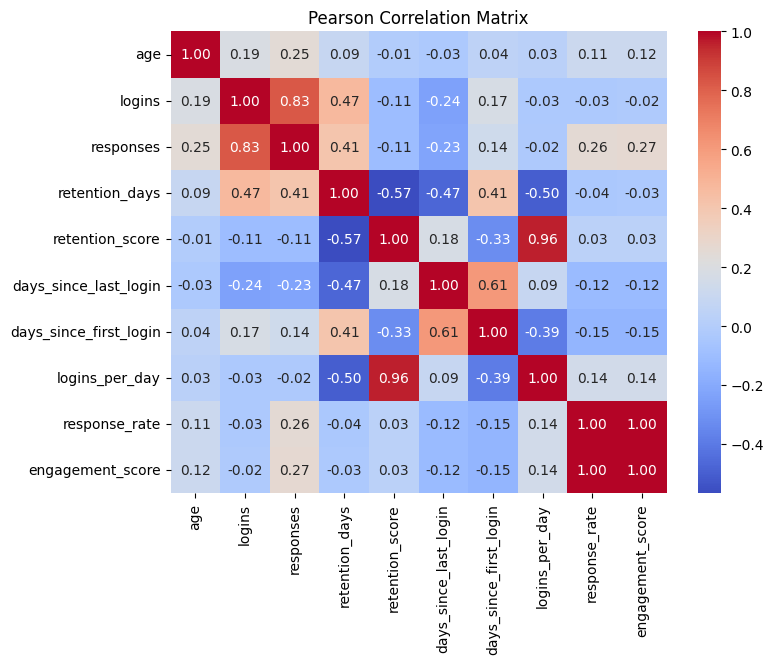

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

We can see that logins-responses (0.83) have a relatively strong linear relationship, age-responses(0.25), age-logins(0.19) have a weak linear relationship, and age-days_since_last_login(-0.04) have almost no linear relationship. We didn’t mention the derived variables since we know why.

Up to now, we implemented the correlation among numerical variables. Let’s now create our very first class and iterate it as we proceed.

In [8]:
class DependencyAnalysis:

    def __init__(self, data, numeric_cols):
        self.df = data.copy()
        self.numeric_cols = numeric_cols

    def analyze_numeric_correlations(self):
        corr_matrix = self.df[self.numeric_cols].corr(method='pearson')

        display(corr_matrix)

        plt.figure(figsize=(8,6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f"Pearson Correlation Matrix")
        plt.show()

        return corr_matrix


In [9]:
dep_analyzer1 = DependencyAnalysis(
    data=df_augmented,
    numeric_cols=[
        'age', 'logins', 'responses',
        'retention_days', 'retention_score',
        'days_since_last_login', 'days_since_first_login',
        'logins_per_day', 'response_rate', 'engagement_score'
    ]
)

,age,logins,responses,retention_days,retention_score,days_since_last_login,days_since_first_login,logins_per_day,response_rate,engagement_score
age,1.000000,0.186448,0.248413,0.090054,-0.010013,-0.034967,0.044959,0.028015,0.114867,0.116893
logins,0.186448,1.000000,0.826063,0.469905,-0.106988,-0.238943,0.174880,-0.029539,-0.032815,-0.021783
responses,0.248413,0.826063,1.000000,0.406063,-0.106357,-0.230733,0.136094,-0.024354,0.258063,0.267156
retention_days,0.090054,0.469905,0.406063,1.000000,-0.567860,-0.473318,0.407734,-0.502692,-0.036016,-0.031998
retention_score,-0.010013,-0.106988,-0.106357,-0.567860,1.000000,0.175435,-0.328043,0.960768,0.034669,0.034757
days_since_last_login,-0.034967,-0.238943,-0.230733,-0.473318,0.175435,1.000000,0.611334,0.091082,-0.115160,-0.119547
days_since_first_login,0.044959,0.174880,0.136094,0.407734,-0.328043,0.611334,1.000000,-0.392672,-0.150410,-0.151220
logins_per_day,0.028015,-0.029539,-0.024354,-0.502692,0.960768,0.091082,-0.392672,1.000000,0.143634,0.144708
response_rate,0.114867,-0.032815,0.258063,-0.036016,0.034669,-0.115160,-0.150410,0.143634,1.000000,0.999928
engagement_score,0.116893,-0.021783,0.267156,-0.031998,0.034757,-0.119547,-0.151220,0.144708,0.999928,1.000000


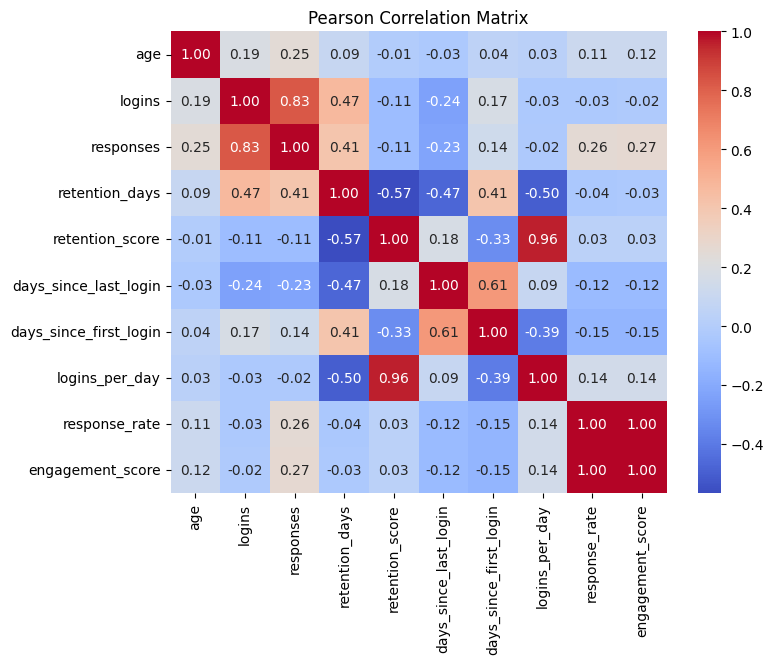

In [10]:
corr_matrix = dep_analyzer1.analyze_numeric_correlations()

covering edge cases

Edge Cases:
1. If numerical columns are not presented, it is set be to None. If it is none, one way to handle this is to select the numeric datatypes among the variables.

2. If not enough numerical columns in the dataset to conduct correlation analysis, i.e. only 1 or no columns exist, we shall print a warning or throw an exception.

3. (Optional improvement) pandas.DataFrame.corr method has other methods such as kendall, spearman, etc. given in the documentation. So we can add that as an argument

4. (Optional improvement) Plot might not be required (optional case)



In [11]:
class DependencyAnalysis:

    def __init__(self, data, numeric_cols=None):
        self.df = data.copy()

        if numeric_cols is None:
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        self.numeric_cols = numeric_cols

    def analyze_numeric_correlations(self, method='pearson', plot=True):
        if len(self.numeric_cols) < 2:
            print("Not enough numeric columns to compute correlation.")
            return None

        corr_matrix = self.df[self.numeric_cols].corr(method=method)

        display(corr_matrix)
        if plot:
          plt.figure(figsize=(8,6))
          sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
          plt.title(f"{method.capitalize()} Correlation Matrix")
          plt.show()

        return corr_matrix


In [12]:
dep_analyzer2 = DependencyAnalysis(
    data=df_augmented,
    numeric_cols=[
        'age', 'logins', 'responses',
        'retention_days', 'retention_score',
        'days_since_last_login', 'days_since_first_login',
        'logins_per_day', 'response_rate', 'engagement_score'
    ]
)

In [13]:
corr_matrix = dep_analyzer2.analyze_numeric_correlations(method='pearson', plot = False)

,age,logins,responses,retention_days,retention_score,days_since_last_login,days_since_first_login,logins_per_day,response_rate,engagement_score
age,1.000000,0.186448,0.248413,0.090054,-0.010013,-0.034967,0.044959,0.028015,0.114867,0.116893
logins,0.186448,1.000000,0.826063,0.469905,-0.106988,-0.238943,0.174880,-0.029539,-0.032815,-0.021783
responses,0.248413,0.826063,1.000000,0.406063,-0.106357,-0.230733,0.136094,-0.024354,0.258063,0.267156
retention_days,0.090054,0.469905,0.406063,1.000000,-0.567860,-0.473318,0.407734,-0.502692,-0.036016,-0.031998
retention_score,-0.010013,-0.106988,-0.106357,-0.567860,1.000000,0.175435,-0.328043,0.960768,0.034669,0.034757
days_since_last_login,-0.034967,-0.238943,-0.230733,-0.473318,0.175435,1.000000,0.611334,0.091082,-0.115160,-0.119547
days_since_first_login,0.044959,0.174880,0.136094,0.407734,-0.328043,0.611334,1.000000,-0.392672,-0.150410,-0.151220
logins_per_day,0.028015,-0.029539,-0.024354,-0.502692,0.960768,0.091082,-0.392672,1.000000,0.143634,0.144708
response_rate,0.114867,-0.032815,0.258063,-0.036016,0.034669,-0.115160,-0.150410,0.143634,1.000000,0.999928
engagement_score,0.116893,-0.021783,0.267156,-0.031998,0.034757,-0.119547,-0.151220,0.144708,0.999928,1.000000


__init__ method is a constructor. It is used to set some variables as an instance of this class is created. We shall pick a self-explanatory name for our correlation method analyze_numeric_correlations.


## Categorical vs Categorical

To investigate the relationship among the categorical variables in our dataset, we shall use the Chi-square test of independence. We have a problem here. In the documentation,  it is stated that the pandas.DataFrame.corr method excludes NA/null values. But for the Chi-Square comparison, we need to handle missing values by ourselves. To this end, we create a subset of the dataset without missing values of two categories for each mutual comparison.

In [14]:
categorical_cols=['gender', 'country', 'age_group', 'is_young_player', 'is_veteran_player']

In [15]:
from scipy.stats import chi2_contingency

In [16]:
cat_pairs = []
for i in range(len(categorical_cols)):
    for j in range(i + 1, len(categorical_cols)):
        cat1 = categorical_cols[i]
        cat2 = categorical_cols[j]

        subset = df_augmented[[cat1, cat2]].dropna()

        contingency_table = pd.crosstab(subset[cat1], subset[cat2])
        chi2, pval, dof, expected = chi2_contingency(contingency_table, correction=False)
        cat_pairs.append((cat1, cat2, chi2, pval, expected, dof))

In [17]:
results_df = pd.DataFrame(cat_pairs, columns=['Cat1', 'Cat2', 'Chi2', 'p-value', 'expected', 'dof'])
results_df.sort_values('p-value')

,Cat1,Cat2,Chi2,p-value,expected,dof
7,age_group,is_young_player,10964.000000,0.000000e+00,"[[602.0569135352061, 413.94308646479385], [204...",4
1,gender,age_group,366.568801,2.623912e-74,"[[302.8068244358833, 1030.3843331498808, 1254....",8
2,gender,is_young_player,272.575564,6.470954e-60,"[[1973.163913595934, 1330.836086404066], [3684...",2
8,age_group,is_veteran_player,199.098668,5.870198e-42,"[[660.3443998540679, 355.65560014593217], [224...",4
9,is_young_player,is_veteran_player,135.929096,2.067842e-31,"[[4302.031046931408, 2310.968953068592], [2905...",1
3,gender,is_veteran_player,111.011969,7.835330e-25,"[[2145.890724269377, 1158.1092757306226], [400...",2
0,gender,country,139.382832,6.626482e-20,"[[120.57630313884438, 173.76284286926196, 88.2...",20
4,country,age_group,163.993908,6.007881e-17,"[[36.63756037503551, 124.87678757458093, 152.5...",40
6,country,is_veteran_player,66.184090,2.404555e-10,"[[261.8555763823805, 141.14442361761948], [374...",10
5,country,is_young_player,65.295880,3.557883e-10,"[[241.15791940018744, 161.84208059981256], [34...",10


Basically, for a p-value that is less than 0.05, we reject the null hypothesis and assume that the difference is significant. While the Chi-square value is not enough to decide by itself, higher values suggest stronger evidence to reject the null hypothesis. A higher degree of freedom is better, as long as we satisfy the assumption of minimum expected frequency.
For instance gender-country have a significant association with chi = 139.38, p-value ≈ 0.000, dof= 20,


Since the Chi-square test works by creating contingency tables to compare expected frequencies for each category, each category needs to have enough balanced data to make a comparison. In reference [4], and many other resources, it is commonly stated that if the degree of freedom is more than 1 and %80 of the cells satisfy the expected frequency of at least 5, the test is admitted as reliable.


So as we are mindful of it, we can write the expected frequency in a more understandable manner


In [18]:
cat_pairs = []
for i in range(len(categorical_cols)):
    for j in range(i + 1, len(categorical_cols)):
        cat1 = categorical_cols[i]
        cat2 = categorical_cols[j]

        subset = df_augmented[[cat1, cat2]].dropna()

        contingency_table = pd.crosstab(subset[cat1], subset[cat2])
        chi2, pval, dof, expected = chi2_contingency(contingency_table, correction=False)

        expected_flat = expected.flatten()
        low_expected_count = (expected_flat < 5).sum()
        low_expected_percentage = (low_expected_count / len(expected_flat)) * 100

        cat_pairs.append({
            'Cat1': cat1,
            'Cat2': cat2,
            'Chi2': chi2,
            'p-value': pval,
            'dof': dof,
            'low_expected_count': low_expected_count,
            'low_expected_%': low_expected_percentage
        })

results_df = pd.DataFrame(cat_pairs)
display(results_df.sort_values('p-value'))

,Cat1,Cat2,Chi2,p-value,dof,low_expected_count,low_expected_%
7,age_group,is_young_player,10964.000000,0.000000e+00,4,0,0.0
1,gender,age_group,366.568801,2.623912e-74,8,0,0.0
2,gender,is_young_player,272.575564,6.470954e-60,2,0,0.0
8,age_group,is_veteran_player,199.098668,5.870198e-42,4,0,0.0
9,is_young_player,is_veteran_player,135.929096,2.067842e-31,1,0,0.0
3,gender,is_veteran_player,111.011969,7.835330e-25,2,0,0.0
0,gender,country,139.382832,6.626482e-20,20,0,0.0
4,country,age_group,163.993908,6.007881e-17,40,0,0.0
6,country,is_veteran_player,66.184090,2.404555e-10,10,0,0.0
5,country,is_young_player,65.295880,3.557883e-10,10,0,0.0


In [19]:
cat_pairs = []
for i in range(len(categorical_cols)):
    for j in range(i + 1, len(categorical_cols)):
        cat1 = categorical_cols[i]
        cat2 = categorical_cols[j]

        subset = df_augmented[[cat1, cat2]].dropna()

        if subset[cat1].nunique() > 1 and subset[cat2].nunique() > 1: # To eliminate a possible edge case
            contingency_table = pd.crosstab(subset[cat1], subset[cat2])
            chi2, pval, dof, expected = chi2_contingency(contingency_table, correction=False)

            expected_flat = expected.flatten()
            low_expected_count = (expected_flat < 5).sum()
            low_expected_percentage = (low_expected_count / len(expected_flat)) * 100

            cat_pairs.append({
                'Cat1': cat1,
                'Cat2': cat2,
                'Chi2': chi2,
                'p-value': pval,
                'dof': dof,
                'low_expected_count': low_expected_count,
                'low_expected_%': low_expected_percentage
            })

results_df = pd.DataFrame(cat_pairs)
display(results_df.sort_values('p-value'))


,Cat1,Cat2,Chi2,p-value,dof,low_expected_count,low_expected_%
7,age_group,is_young_player,10964.000000,0.000000e+00,4,0,0.0
1,gender,age_group,366.568801,2.623912e-74,8,0,0.0
2,gender,is_young_player,272.575564,6.470954e-60,2,0,0.0
8,age_group,is_veteran_player,199.098668,5.870198e-42,4,0,0.0
9,is_young_player,is_veteran_player,135.929096,2.067842e-31,1,0,0.0
3,gender,is_veteran_player,111.011969,7.835330e-25,2,0,0.0
0,gender,country,139.382832,6.626482e-20,20,0,0.0
4,country,age_group,163.993908,6.007881e-17,40,0,0.0
6,country,is_veteran_player,66.184090,2.404555e-10,10,0,0.0
5,country,is_young_player,65.295880,3.557883e-10,10,0,0.0


In [20]:
class DependencyAnalysis:

    def __init__(self, data, numeric_cols=None, categorical_cols=None):
        self.df = data.copy()

        if numeric_cols is None:
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()

        if categorical_cols is None: # here we covered the same edge case for the case categorical_cols is not presented in the constructor
            categorical_cols = self.df.select_dtypes(include=['object','category','bool']).columns.tolist()

        self.numeric_cols = numeric_cols

    def analyze_numeric_correlations(self, method='pearson', plot=True):
        if len(self.numeric_cols) < 2:
            print("Not enough numeric columns to compute correlation.")
            return None

        corr_matrix = self.df[self.numeric_cols].corr(method=method)

        display(corr_matrix)
        if plot:
          plt.figure(figsize=(8,6))
          sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
          plt.title(f"{method.capitalize()} Correlation Matrix")
          plt.show()

        return corr_matrix


    def analyze_categorical_associations(self):
        cat_pairs = []
        for i in range(len(categorical_cols)):
            for j in range(i + 1, len(categorical_cols)):
                cat1 = categorical_cols[i]
                cat2 = categorical_cols[j]

                subset = df_augmented[[cat1, cat2]].dropna()

                if subset[cat1].nunique() > 1 and subset[cat2].nunique() > 1:
                    contingency_table = pd.crosstab(subset[cat1], subset[cat2])
                    chi2, pval, dof, expected = chi2_contingency(contingency_table, correction=False)

                    expected_flat = expected.flatten()
                    low_expected_count = (expected_flat < 5).sum()
                    low_expected_percentage = (low_expected_count / len(expected_flat)) * 100

                    cat_pairs.append({
                        'Cat1': cat1,
                        'Cat2': cat2,
                        'Chi2': chi2,
                        'p-value': pval,
                        'dof': dof,
                        'low_expected_count': low_expected_count,
                        'low_expected_%': low_expected_percentage
                    })

        results_df = pd.DataFrame(cat_pairs)
        display(results_df.sort_values('p-value'))

In [21]:
dep_analyzer3= DependencyAnalysis(
    data=df_augmented,
    numeric_cols=[
        'age', 'logins', 'responses',
        'retention_days', 'retention_score',
        'days_since_last_login', 'days_since_first_login',
        'logins_per_day', 'response_rate', 'engagement_score'
    ],
    categorical_cols=['gender', 'country', 'age_group', 'is_young_player', 'is_veteran_player']
)

In [22]:
cat_analysis = dep_analyzer3.analyze_categorical_associations()

,Cat1,Cat2,Chi2,p-value,dof,low_expected_count,low_expected_%
7,age_group,is_young_player,10964.000000,0.000000e+00,4,0,0.0
1,gender,age_group,366.568801,2.623912e-74,8,0,0.0
2,gender,is_young_player,272.575564,6.470954e-60,2,0,0.0
8,age_group,is_veteran_player,199.098668,5.870198e-42,4,0,0.0
9,is_young_player,is_veteran_player,135.929096,2.067842e-31,1,0,0.0
3,gender,is_veteran_player,111.011969,7.835330e-25,2,0,0.0
0,gender,country,139.382832,6.626482e-20,20,0,0.0
4,country,age_group,163.993908,6.007881e-17,40,0,0.0
6,country,is_veteran_player,66.184090,2.404555e-10,10,0,0.0
5,country,is_young_player,65.295880,3.557883e-10,10,0,0.0


### Numerical vs Categoricals

Finally, we will be investigating the relationship between categorical and numerical variables. We know (also from our previous repositories) that the two important tests here are ANOVA and Kruskal-Wallis.

In [23]:
numeric_cols=[
    'age', 'logins', 'responses',
    'retention_days', 'retention_score',
    'days_since_last_login', 'days_since_first_login',
    'logins_per_day', 'response_rate', 'engagement_score'
]

categorical_cols=['gender', 'country', 'age_group', 'is_young_player', 'is_veteran_player']



 To handle the missing values, we again create a subset of two variables mutually for each comparison. Let’s go for ANOVA first, and expand our understanding step by step.

In [32]:
from scipy.stats import f_oneway,kruskal
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

results = []
for cat_col in categorical_cols:
    for num_col in numeric_cols:

        df_subset = df_augmented[[cat_col, num_col]].dropna()

        groups = [group[num_col].values for _, group in df_subset.groupby(cat_col, observed=True)]

        stat, pval = f_oneway(*groups)
        #stat, pval = kruskal(*groups)

        results.append({
          'categorical': cat_col,
          'numeric': num_col,
          'statistic': stat,
          'p-value': pval
      })

results_df = pd.DataFrame(results)
display(results_df.sort_values('p-value'))

,categorical,numeric,statistic,p-value
45,is_veteran_player,days_since_last_login,2026.980817,0.000000e+00
43,is_veteran_player,retention_days,22306.375889,0.000000e+00
42,is_veteran_player,responses,3748.486399,0.000000e+00
41,is_veteran_player,logins,5338.265226,0.000000e+00
30,is_young_player,age,11507.020406,0.000000e+00
44,is_veteran_player,retention_score,1794.269427,0.000000e+00
20,age_group,age,21101.540474,0.000000e+00
46,is_veteran_player,days_since_first_login,1324.972594,3.955410e-274
22,age_group,responses,157.614366,5.455206e-131
21,age_group,logins,96.410029,9.364474e-81


A high F-statistic and a small p-value indicate a significant difference. For instance, is_veteran_player and retention_days (F = 22306.38, p ≈ 0) show that there is a significant difference between veteran and non-veteran players in terms of how many days they play.


Only if the assumptions of ANOVA were met. We need to make further analysis to see if the data meet some assumptions to conduct ANOVA. Otherwise, we shall conduct a non-parametric alternative, that is Kruskal-Wallis test.
Before we conduct f_oneway(*groups) or kruskal(*groups) we need to decide if the assumptions are satisfied or not.


We shall check the normality with Shapiro-Wilk's test, and the homogeneity of variances with Leneve's test. The approach is to declare a boolean and set it based on the p-value of Shapiro-Wilk's test, and keep this with other values.

In [37]:
from scipy.stats import f_oneway, kruskal, shapiro, levene


results = []

for cat_col in categorical_cols:
    for num_col in numeric_cols:
        df_subset = df_augmented[[cat_col, num_col]].dropna()

        groups = [group[num_col].values for _, group in df_subset.groupby(cat_col, observed=True)]

        #checking normality assumption
        normal_groups = True
        for g in groups:
            if len(g) >= 3:
                # For large groups, take a random sample of 5000 points
                if len(g) > 5000:
                    g_sample = np.random.choice(g, size=5000, replace=False)
                    shapiro_stat, shapiro_p = shapiro(g_sample)
                else:
                    shapiro_stat, shapiro_p = shapiro(g)

                if shapiro_p < 0.05:
                    normal_groups = False
                    break

        # Checking homogeneity of variances assumption
        leve_stat, leve_p = levene(*groups)
        homoscedastic = (leve_p >= 0.05)

        if normal_groups and homoscedastic:
            stat, pval = f_oneway(*groups)
            test_used = 'ANOVA'
        else:
            stat, pval = kruskal(*groups)
            test_used = 'Kruskal-Wallis'


        results.append({
            'categorical': cat_col,
            'numeric': num_col,
            'test': test_used,
            'statistic': stat,
            'p-value': pval
        })

results_df = pd.DataFrame(results)
display(results_df.sort_values('p-value'))

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,categorical,numeric,test,statistic,p-value
43,is_veteran_player,retention_days,Kruskal-Wallis,6680.580842,0.000000e+00
20,age_group,age,Kruskal-Wallis,9974.275642,0.000000e+00
41,is_veteran_player,logins,Kruskal-Wallis,5848.348677,0.000000e+00
47,is_veteran_player,logins_per_day,Kruskal-Wallis,3983.957912,0.000000e+00
42,is_veteran_player,responses,Kruskal-Wallis,3879.694760,0.000000e+00
30,is_young_player,age,Kruskal-Wallis,7959.048885,0.000000e+00
44,is_veteran_player,retention_score,Kruskal-Wallis,2902.280997,0.000000e+00
45,is_veteran_player,days_since_last_login,Kruskal-Wallis,1167.015230,8.992761e-256
46,is_veteran_player,days_since_first_login,Kruskal-Wallis,895.420575,9.712599e-197
22,age_group,responses,Kruskal-Wallis,544.649635,1.470664e-116


In [41]:
class DependencyAnalysis:

    def __init__(self, data, numeric_cols=None, categorical_cols=None):
        self.df = data.copy()

        if numeric_cols is None:
            numeric_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()

        if categorical_cols is None:
            categorical_cols = self.df.select_dtypes(include=['object','category','bool']).columns.tolist()

        self.numeric_cols = numeric_cols

    def analyze_numeric_correlations(self, method='pearson', plot=True):
        if len(self.numeric_cols) < 2:
            print("Not enough numeric columns to compute correlation.")
            return None

        corr_matrix = self.df[self.numeric_cols].corr(method=method)

        display(corr_matrix)
        if plot:
          plt.figure(figsize=(8,6))
          sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
          plt.title(f"{method.capitalize()} Correlation Matrix")
          plt.show()

        return corr_matrix


    def analyze_categorical_associations(self):
        cat_pairs = []
        for i in range(len(categorical_cols)):
            for j in range(i + 1, len(categorical_cols)):
                cat1 = categorical_cols[i]
                cat2 = categorical_cols[j]

                subset = df_augmented[[cat1, cat2]].dropna()

                if subset[cat1].nunique() > 1 and subset[cat2].nunique() > 1:
                    contingency_table = pd.crosstab(subset[cat1], subset[cat2])
                    chi2, pval, dof, expected = chi2_contingency(contingency_table, correction=False)

                    expected_flat = expected.flatten()
                    low_expected_count = (expected_flat < 5).sum()
                    low_expected_percentage = (low_expected_count / len(expected_flat)) * 100

                    cat_pairs.append({
                        'Cat1': cat1,
                        'Cat2': cat2,
                        'Chi2': chi2,
                        'p-value': pval,
                        'dof': dof,
                        'low_expected_count': low_expected_count,
                        'low_expected_%': low_expected_percentage
                    })

        results_df = pd.DataFrame(cat_pairs)
        display(results_df.sort_values('p-value'))

    def analyze_numeric_categorical(self, numeric=None, categorical=None, test='anova'):

        results = []

        for cat_col in categorical_cols:
            for num_col in numeric_cols:
                df_subset = df_augmented[[cat_col, num_col]].dropna()
                if df_subset[cat_col].nunique() < 2:
                    continue
                groups = [grp[num_col].values for _, grp in df_subset.groupby(cat_col, observed=True)]

                normal_groups = True
                for g in groups:
                    if len(g) >= 3:
                        # For large groups, take a random sample of 5000 points
                        if len(g) > 5000:
                            g_sample = np.random.choice(g, size=5000, replace=False)
                            shapiro_stat, shapiro_p = shapiro(g_sample)
                        else:
                            shapiro_stat, shapiro_p = shapiro(g)

                        if shapiro_p < 0.05:
                            normal_groups = False
                            break

                # Checking homogeneity of variances assumption
                leve_stat, leve_p = levene(*groups)
                homoscedastic = (leve_p >= 0.05)

                if normal_groups and homoscedastic:
                    stat, pval = f_oneway(*groups)
                    test_used = 'ANOVA'
                else:
                    stat, pval = kruskal(*groups)
                    test_used = 'Kruskal-Wallis'

                results.append({
                    'categorical': cat_col,
                    'numeric': num_col,
                    'test': test_used,
                    'statistic': stat,
                    'p-value': pval
                })

        results_df = pd.DataFrame(results)
        display(results_df.sort_values('p-value'))
        return results_df


In [42]:
dep_analyzer4= DependencyAnalysis(
    data=df_augmented,
    numeric_cols=[
        'age', 'logins', 'responses',
        'retention_days', 'retention_score',
        'days_since_last_login', 'days_since_first_login',
        'logins_per_day', 'response_rate', 'engagement_score'
    ],
    categorical_cols=['gender', 'country', 'age_group', 'is_young_player', 'is_veteran_player']
)

In [43]:
num_cat_analysis = dep_analyzer4.analyze_numeric_categorical()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,categorical,numeric,test,statistic,p-value
43,is_veteran_player,retention_days,Kruskal-Wallis,6680.580842,0.000000e+00
20,age_group,age,Kruskal-Wallis,9974.275642,0.000000e+00
41,is_veteran_player,logins,Kruskal-Wallis,5848.348677,0.000000e+00
47,is_veteran_player,logins_per_day,Kruskal-Wallis,3983.957912,0.000000e+00
42,is_veteran_player,responses,Kruskal-Wallis,3879.694760,0.000000e+00
30,is_young_player,age,Kruskal-Wallis,7959.048885,0.000000e+00
44,is_veteran_player,retention_score,Kruskal-Wallis,2902.280997,0.000000e+00
45,is_veteran_player,days_since_last_login,Kruskal-Wallis,1167.015230,8.992761e-256
46,is_veteran_player,days_since_first_login,Kruskal-Wallis,895.420575,9.712599e-197
22,age_group,responses,Kruskal-Wallis,544.649635,1.470664e-116
